#  Классификация изображений с помощью сверточных нейронных сетей

__Автор задач: Блохин Н.В. (NVBlokhin@fa.ru)__

Материалы:
* Deep Learning with PyTorch (2020) Авторы: Eli Stevens, Luca Antiga, Thomas Viehmann
* https://pytorch.org/docs/stable/nn.html#convolution-layers
* https://pytorch.org/vision/0.16/transforms.html#v2-api-reference-recommended
* https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
* https://pytorch.org/vision/main/generated/torchvision.datasets.ImageFolder.html
* https://kozodoi.me/blog/20210308/compute-image-stats
* https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.matshow.html

## Задачи для совместного разбора

1\. Рассмотрите основные возможности по созданию датасетов из `torchvision` и примеры работы основных слоев для создания сверточных нейронных сетей для анализа изображений.

In [19]:
from torchvision.datasets import CIFAR10
import torchvision.transforms.v2 as T

In [ ]:
transform = T.Compose(
    [
      T.ToTensor(),
      T.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
    ]
)

dataset = CIFAR10(
    root="./tmp",
    train=True,
    download=True,
    transform=transform
)

In [ ]:
x = dataset[0][0]

In [ ]:
import matplotlib.pyplot as plt

plt.imshow(dataset[0][0])

2\. Реализуйте типовую архитектуру CNN для классификации изображений.

In [ ]:
import torch as th
import torch.nn as nn

In [71]:
x.shape # channels x h x w

NameError: name 'x' is not defined

In [ ]:
b = x.unsqueeze(0)
b.shape # batch x channels x h x w

In [ ]:
conv = nn.Conv2d(in_channels=3, out_channels=5, kernel_size=3)

In [ ]:
o = conv(b)
o.shape

torch.Size([1, 5, 30, 30])

In [ ]:
pool = nn.MaxPool2d(kernel_size=2)

In [ ]:
class ConvNet(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=3)
    self.pool1 = nn.MaxPool2d(kernel_size=2)
    self.conv2 = nn.Conv2d(in_channels=6, out_channels=12, kernel_size=3)
    self.pool2 = nn.MaxPool2d(kernel_size=2)

    self.fc = nn.Linear(in_features=12*6*6, out_features=10)

  def forward(self, X):
    # feature extractors
    out = self.conv1(X)
    out = out.relu()
    out = self.pool1(out)
    out = self.conv2(out)
    out = out.relu()
    out = self.pool2(out)   # b x 12 x 6 x 6

    # classifier
    out = th.flatten(out, start_dim=1) # b x 12*6*6
    out = self.fc(out)
    return out

In [ ]:
net = ConvNet()
o = net(b)
o.shape

torch.Size([1, 10])

## Задачи для самостоятельного решения

In [1]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch.nn as nn
import numpy as np
import torch.optim as optim
from sklearn.metrics import accuracy_score

<p class="task" id="1"></p>

### 1
Создайте датасет `CatBreeds` на основе данных из архива `cat_breeds_4.zip`. Используя преобразования `torchvision`, приведите картинки к размеру 300х300 и нормализуйте значения интенсивности пикселей (рассчитайте статистику для нормализации отдельно). Выведите на экран количество картинок в датасете,  размер одной картинки, количество уникальных классов. Разбейте датасет на обучающее и тестовое множество в соотношении 80 на 20%.

- [x] Проверено на семинаре

In [2]:
data_dir = 'data/cat_breeds_4'

cat_dataset = datasets.ImageFolder(root=data_dir)

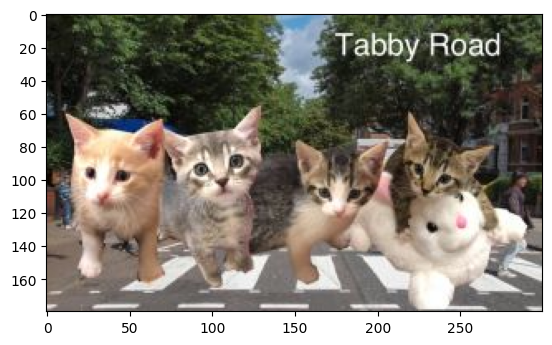

In [3]:
plt.imshow(cat_dataset[5][0]) # ПМ21-5

In [3]:
data_dir = 'data/cat_breeds_4'

transform = transforms.Compose([
    transforms.Resize([300, 300]),
    transforms.ToTensor()  
])

cat_dataset = datasets.ImageFolder(root=data_dir, transform=transform)

loader = DataLoader(cat_dataset, batch_size=len(cat_dataset))
data = next(iter(loader))
mean = data[0].mean(dim=(0, 2, 3))
std = data[0].std(dim=(0, 2, 3))

transform = transforms.Compose([
    transforms.Resize([300, 300]),
    transforms.ToTensor(),
    transforms.Normalize(mean, std) 
])

cat_dataset = datasets.ImageFolder(root=data_dir, transform=transform)

In [4]:
num_images = len(cat_dataset)
print(f"всего картинок: {num_images}")

sample_image, _ = cat_dataset[0]  
image_size = sample_image.size()
print(f"размер картинок: {image_size}")

num_classes = len(cat_dataset.classes)
print(f"количество классов: {num_classes}")


train_size = int(0.8 * num_images)
test_size = num_images - train_size
train_dataset, test_dataset = torch.utils.data.random_split(cat_dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=50)
test_loader = DataLoader(test_dataset, batch_size=50)

print(f"train_size: {len(train_dataset)}")
print(f"test_size: {len(test_dataset)}")

всего картинок: 4000
размер картинок: torch.Size([3, 300, 300])
количество классов: 4
train_size: 3200
test_size: 800


<p class="task" id="2"></p>

### 2
Решите задачу классификации на основе датасета из предыдущего задания, не используя сверточные слои. Постройте график изменения значения функции потерь на обучающем множестве в зависимости от номера эпохи, графики изменения метрики accuracy на обучающем и тестовом множестве в зависимости от эпохи. Выведите на экран итоговое значение метрики accuracy на обучающем и тестовом множестве. Выведите на экран количество параметров модели.   

- [ ] Проверено на семинаре

In [21]:
lr = 0.0001
epochs = 50

model = nn.Sequential(
        nn.Flatten(start_dim=1),
        nn.Linear(3 * 300 * 300, 10),
        nn.ReLU(),
        nn.Linear(10, 4),
)

optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

train_losses_list = []
train_accuracies_list = []
test_accuracies_list = []

for epoch in tqdm(range(epochs)):

    # train
    model.train()
    train_loss = 0.0
    correct_train = 0
    total_train = 0
    
    train_predictions_list = []
    train_labels_list = []
    test_predictions_list = []
    test_labels_list = []

    for images, labels in train_loader:
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, dim=1)

        train_predictions_list.extend(predicted)
        train_labels_list.extend(labels)

    train_accuracy = accuracy_score(train_labels_list, train_predictions_list) 
    train_losses_list.append(train_loss)
    train_accuracies_list.append(train_accuracy)

    # evaluate
    model.eval()
    correct_test = 0
    total_test = 0

    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, dim=1)
            test_predictions_list.extend(predicted)
            test_labels_list.extend(labels)

    test_accuracy = accuracy_score(test_labels_list, test_predictions_list) 
    test_accuracies_list.append(test_accuracy)

print(f"Final train accuracy = {train_accuracies_list[-1]}")
print(f"Final test accuracy = {test_accuracies_list[-1]}")
print(f"Total model parameters = {sum(p.numel() for p in model.parameters())}")

100%|██████████| 50/50 [09:15<00:00, 11.11s/it]

Final train accuracy = 0.71125
Final test accuracy = 0.37625
Total model parameters = 2700054


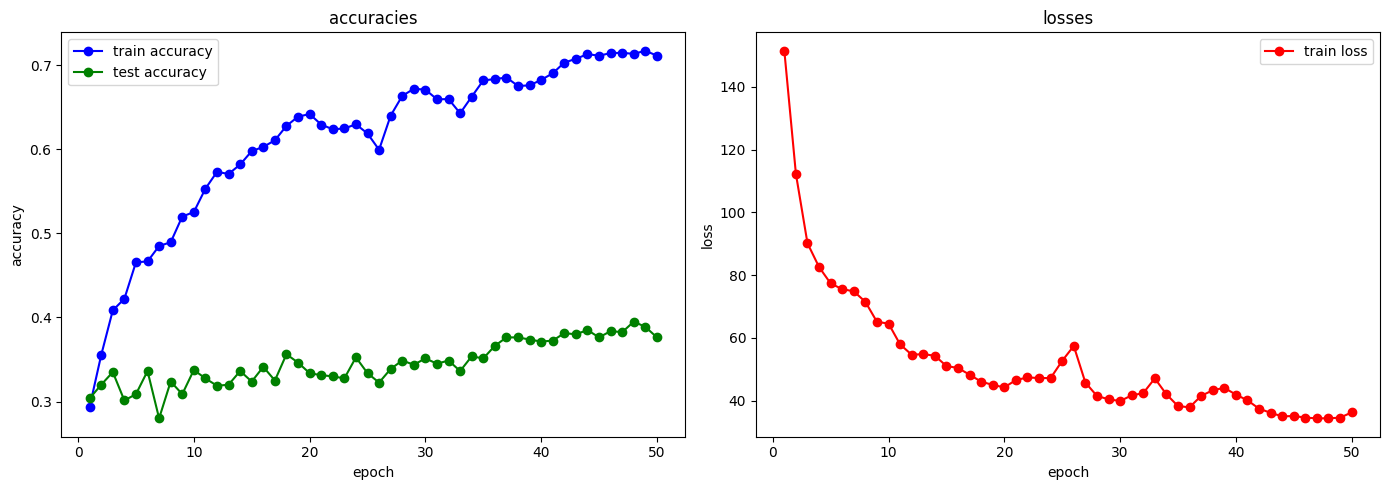

In [22]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))

axs[0].plot(torch.arange(epochs) + 1, train_accuracies_list, label='train accuracy', marker='o', color='b')
axs[0].plot(torch.arange(epochs) + 1, test_accuracies_list, label='test accuracy', marker='o', color='g')
axs[0].set_xlabel('epoch')
axs[0].set_ylabel('accuracy')
axs[0].set_title('accuracies')
axs[0].legend()

axs[1].plot(torch.arange(epochs) + 1, train_losses_list, label='train loss', marker='o', color='r')
axs[1].set_xlabel('epoch')
axs[1].set_ylabel('loss')
axs[1].set_title('losses')
axs[1].legend()

plt.tight_layout()
plt.show()

<p class="task" id="3"></p>

### 3
Напишите функцию, которая выбирает несколько изображений из переданного набора данных и выводит их на экран в виде сетки с указанием над ними названия правильного класса и класса, предсказанного моделью. Воспользовавшись данной функцией, выведите прогнозы итоговой модели из предыдущей задачи по 6 случайным картинкам.

```
def show_examples(model, dataset, k=6):
    pass
```

- [ ] Проверено на семинаре

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


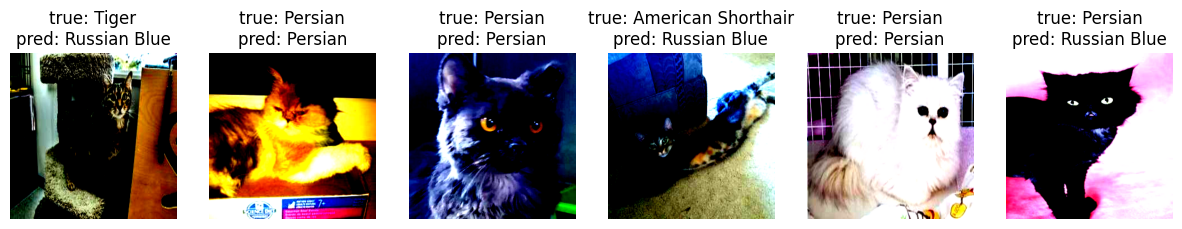

In [65]:
def show_examples(model, dataset, k=6):
    indices = np.random.choice(len(dataset), k, replace=False)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=k, sampler=torch.utils.data.SubsetRandomSampler(indices))

    model.eval()
    with torch.no_grad():
        for images, labels in dataloader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, dim=1)

            fig, axes = plt.subplots(1, k, figsize=(15, 6))
            for idx, ax in enumerate(axes):
                image = images[idx]
                label = cat_dataset.classes[labels[idx].item()]
                prediction = cat_dataset.classes[predicted[idx].item()]
                image = image.permute(1, 2, 0)
                ax.imshow(image)
                ax.set_title(f'true: {label}\npred: {prediction}')
                ax.axis('off')
            plt.show()

show_examples(model, test_dataset)

<p class="task" id="4"></p>

### 4
Решите задачу классификации на основе датасета из первого задания, используя сверточные слои. Постройте график изменения значения функции потерь на обучающем множестве в зависимости от номера эпохи, графики изменения метрики accuracy на обучающем и тестовом множестве в зависимости от эпохи. Выведите на экран итоговое значение метрики accuracy на обучающем и тестовом множестве. Выведите на экран количество параметров модели. Воспользовавшись функцией из предыдущего задания, выведите прогнозы итоговой модели по 6 случайным картинкам.

- [ ] Проверено на семинаре

In [8]:
lr = 0.0001
epochs = 25

# model = nn.Sequential(
#     nn.Conv2d(in_channels=3, out_channels=5, kernel_size=3),
#     nn.ReLU(),
#     nn.MaxPool2d(kernel_size=2),
#     nn.Flatten(start_dim=1),
#     nn.Linear(5 * 149 * 149, 4) 
# )

class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Conv2d(in_channels=3, out_channels=5, kernel_size=3)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2)
        self.flat = nn.Flatten(start_dim=1)
        self.fc = nn.Linear(5 * 149 * 149, 4)

    def forward(self, x):
        out = self.conv(x)
        out = self.relu(out)
        out = self.pool(out)
        out = self.flat(out)
        out = self.fc(out)
        return out

model = ConvNet()
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

train_losses_list = []
train_accuracies_list = []
test_accuracies_list = []

for epoch in tqdm(range(epochs)):

    # train
    model.train()
    train_loss = 0.0
    correct_train = 0
    total_train = 0
    
    train_predictions_list = []
    train_labels_list = []
    test_predictions_list = []
    test_labels_list = []

    for images, labels in train_loader:
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, dim=1)

        train_predictions_list.extend(predicted)
        train_labels_list.extend(labels)

    train_accuracy = accuracy_score(train_labels_list, train_predictions_list) 
    train_losses_list.append(train_loss)
    train_accuracies_list.append(train_accuracy)

    # evaluate
    model.eval()
    correct_test = 0
    total_test = 0

    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, dim=1)
            test_predictions_list.extend(predicted)
            test_labels_list.extend(labels)

    test_accuracy = accuracy_score(test_labels_list, test_predictions_list) 
    test_accuracies_list.append(test_accuracy)

print(f"Final train accuracy = {train_accuracies_list[-1]}")
print(f"Final test accuracy = {test_accuracies_list[-1]}")
print(f"Total model parameters = {sum(p.numel() for p in model.parameters())}")

100%|██████████| 25/25 [10:07<00:00, 24.28s/it]

Final train accuracy = 0.968125
Final test accuracy = 0.42
Total model parameters = 444164


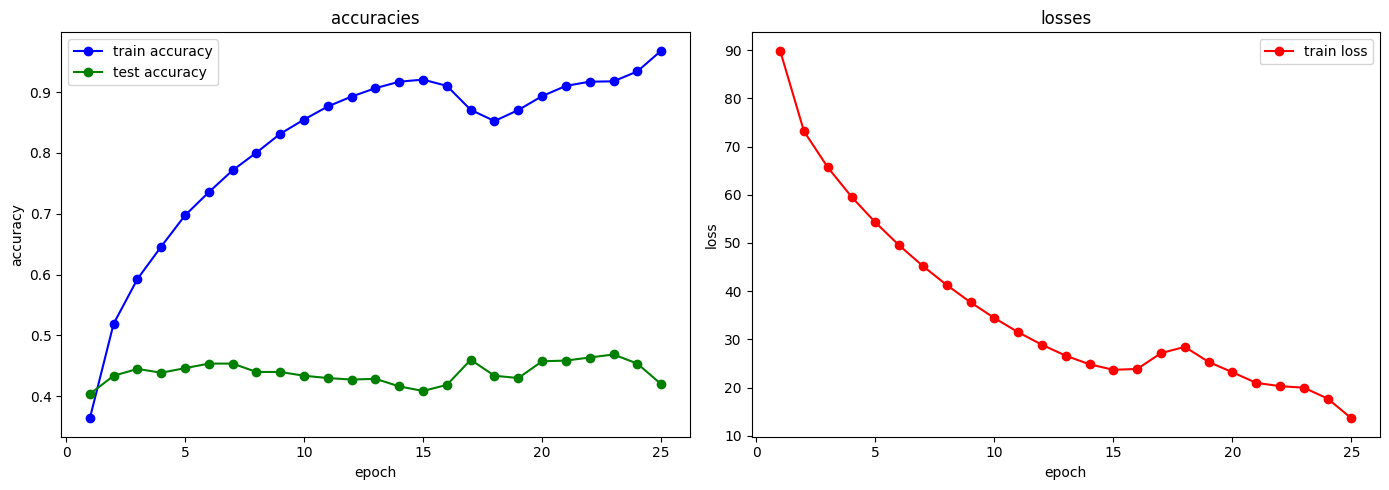

In [9]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))

axs[0].plot(torch.arange(epochs) + 1, train_accuracies_list, label='train accuracy', marker='o', color='b')
axs[0].plot(torch.arange(epochs) + 1, test_accuracies_list, label='test accuracy', marker='o', color='g')
axs[0].set_xlabel('epoch')
axs[0].set_ylabel('accuracy')
axs[0].set_title('accuracies')
axs[0].legend()

axs[1].plot(torch.arange(epochs) + 1, train_losses_list, label='train loss', marker='o', color='r')
axs[1].set_xlabel('epoch')
axs[1].set_ylabel('loss')
axs[1].set_title('losses')
axs[1].legend()

plt.tight_layout()
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


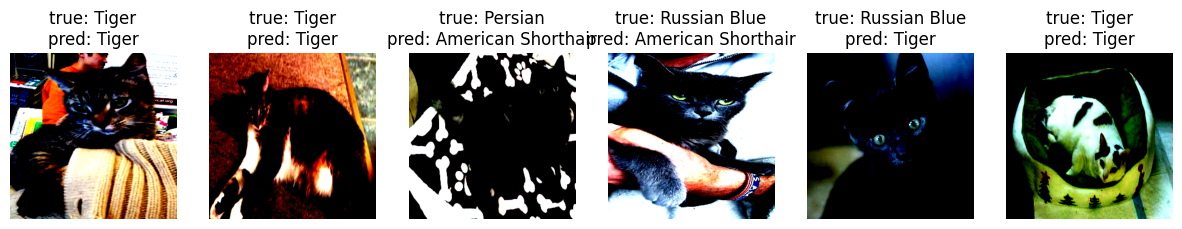

In [12]:
show_examples(model, test_dataset)

<p class="task" id="5"></p>

### 5
Проанализируйте обученную в предыдущей задаче модель, исследовав обученные ядра сверточных слоев. Выберите одно изображение из тестового набора данных и пропустите через первый сверточный слой модели. Визуализируйте полученные карты признаков.

- [ ] Проверено на семинаре

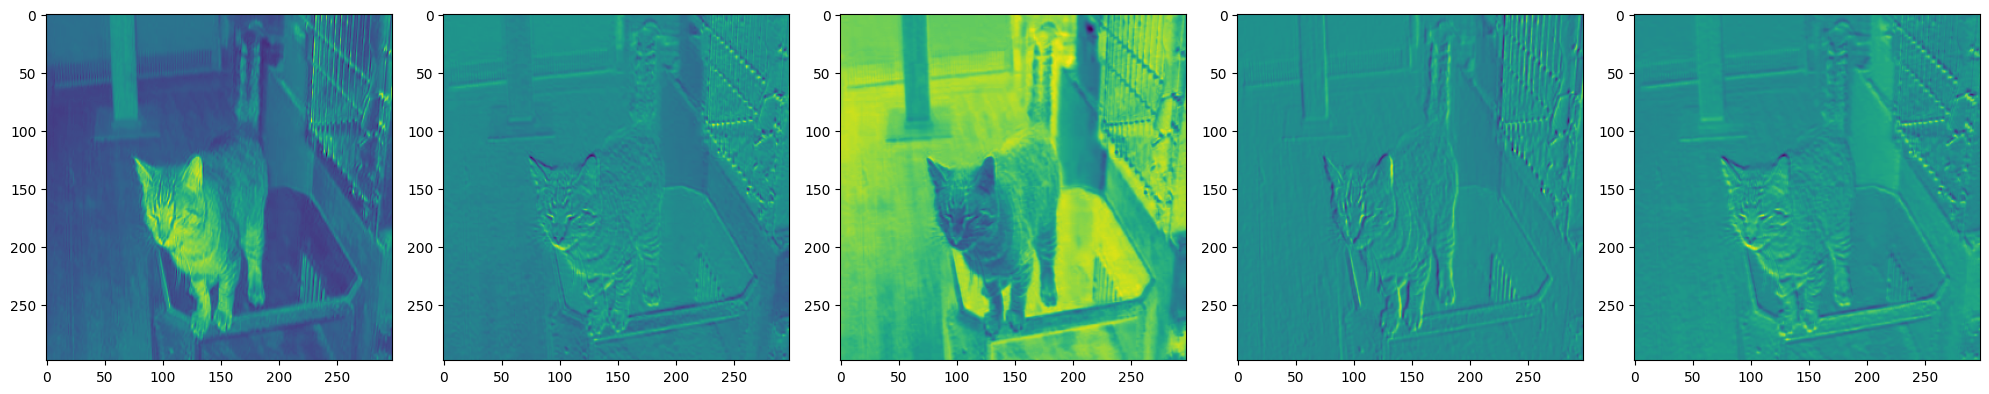

In [31]:
model.eval()
conv = model.conv
image, label = test_dataset[1]

with torch.no_grad():
    image = image.unsqueeze(0)
    extracted_features = conv(image)

fig, axes = plt.subplots(1, 5, figsize=(20, 5))

extracted_feature_map = extracted_features[0, 0].detach().numpy()
axes[0].imshow(extracted_feature_map)
extracted_feature_map = extracted_features[0, 1].detach().numpy()
axes[1].imshow(extracted_feature_map)
extracted_feature_map = extracted_features[0, 2].detach().numpy()
axes[2].imshow(extracted_feature_map)
extracted_feature_map = extracted_features[0, 3].detach().numpy()
axes[3].imshow(extracted_feature_map)
extracted_feature_map = extracted_features[0, 4].detach().numpy()
axes[4].imshow(extracted_feature_map)
plt.tight_layout()

## Обратная связь
- [x] Хочу получить обратную связь по решению